<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/PPG_CNN_GRU_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 0. 전 구간 SBP·DBP 그래프 함수
# =========================
def plot_bp_full_timeseries(sbp, dbp, patient_id="Unknown"):
    """
    전 구간 SBP/DBP 변동을 한 그래프에 표시
    sbp, dbp: 길이 N (예: 2000)
    """
    idx = np.arange(len(sbp))

    plt.figure(figsize=(16, 6))
    plt.plot(idx, sbp, color='red', linewidth=2, label='SBP')
    plt.plot(idx, dbp, color='blue', linewidth=2, label='DBP')

    # 평균선
    plt.axhline(np.mean(sbp), color='darkred', linestyle='--', linewidth=1.5,
                label=f"SBP Mean: {np.mean(sbp):.1f}")
    plt.axhline(np.mean(dbp), color='darkblue', linestyle='--', linewidth=1.5,
                label=f"DBP Mean: {np.mean(dbp):.1f}")

    # SBP - DBP 영역 (Pulse Pressure)
    plt.fill_between(idx, sbp, dbp, where=(sbp > dbp),
                     color='purple', alpha=0.15, label='Pulse Pressure')

    plt.title(f"Blood Pressure Variation Over Time (Patient: {patient_id})", fontsize=15)
    plt.xlabel("Segment Index (0~N-1)", fontsize=12)
    plt.ylabel("Blood Pressure (mmHg)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [7]:
# 1. MAT 로딩 함수 (PPG only + SBP/DBP 반환)
# =========================
def load_ppg_bp_from_mat(mat_path, max_segments=2000):
    """
    mat_path: p096530.mat 같은 파일 경로
    max_segments: 앞에서 사용할 최대 세그먼트 수 (시간순)
    return:
        X_all: (N, L, 1)  PPG
        y_all: (N, 2)     [SBP, DBP]
        patient_id: 문자열 (예: 'p096530')
        sbp_sorted: (N,)
        dbp_sorted: (N,)
    """
    f = h5py.File(mat_path, "r")
    subj = f["Subj_Wins"]
    refs = f["#refs#"]

    def read_cell(obj, idx):
        ref = obj[0, idx]
        return np.array(refs[ref])

    N_total = subj["PPG_F"].shape[1]

    ppg_list = []
    sbp_list = []
    dbp_list = []
    t_list   = []

    for i in range(N_total):
        # PPG: (1, L) -> (L,)
        ppg = read_cell(subj["PPG_F"], i).astype(np.float32).reshape(-1)
        ppg_list.append(ppg)

        # SBP/DBP: (1,1) -> scalar
        sbp = read_cell(subj["SegSBP"], i).astype(np.float32)[0, 0]
        dbp = read_cell(subj["SegDBP"], i).astype(np.float32)[0, 0]
        sbp_list.append(sbp)
        dbp_list.append(dbp)

        # 시간 정보 (정렬용)
        T  = read_cell(subj["T"], i).astype(np.float64)
        t_list.append(float(T[0, 0]))

    ppg_arr = np.stack(ppg_list, axis=0)
    sbp_arr = np.array(sbp_list)
    dbp_arr = np.array(dbp_list)
    t_arr   = np.array(t_list)

    # 환자 ID
    subj_id_arr = read_cell(subj["SubjectID"], 0)
    patient_id = "".join(chr(int(c)) for c in subj_id_arr.reshape(-1))

    # 시간 순 정렬
    order = np.argsort(t_arr)
    ppg_sorted = ppg_arr[order]
    sbp_sorted = sbp_arr[order]
    dbp_sorted = dbp_arr[order]

    # 앞 max_segments만 사용
    if ppg_sorted.shape[0] < max_segments:
        raise ValueError(f"{mat_path}: 세그먼트 {max_segments}개 필요, 현재 {ppg_sorted.shape[0]}개")

    ppg_sorted = ppg_sorted[:max_segments]
    sbp_sorted = sbp_sorted[:max_segments]
    dbp_sorted = dbp_sorted[:max_segments]

    X_all = ppg_sorted[..., np.newaxis]                 # (N, L, 1)
    y_all = np.stack([sbp_sorted, dbp_sorted], axis=1)  # (N, 2)

    f.close()

    print(f"{mat_path} 로드 완료. 환자: {patient_id}, 세그먼트: {X_all.shape[0]}, 길이: {X_all.shape[1]}")
    return X_all, y_all, patient_id, sbp_sorted, dbp_sorted

In [8]:
# 2. PPG CNN+GRU 모델 정의
# =========================
def build_ppg_cnn_gru(input_shape):
    """
    PPG only -> [SBP, DBP] 회귀
    CNN + GRU
    input_shape: (L, 1)
    """
    inp = layers.Input(shape=input_shape)

    # CNN feature extractor
    x = layers.Conv1D(32, 7, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)

    # GRU
    x = layers.GRU(64, return_sequences=False)(x)

    # Dense
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, activation="linear")(x)  # [SBP, DBP]

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse"
    )
    return model

In [9]:
# 3. A로 학습 → A/B에 테스트 (CNN+GRU) + 전 구간 그래프
# =========================
def train_A_and_test_on_A_and_B_gru(mat_A, mat_B):
    """
    mat_A: A 환자 .mat 경로
    mat_B: B 환자 .mat 경로

    - A: 0~1599 = train+val, 1600~1999 = test_A
      * train: 0~1279
      * val  : 1280~1599
    - B: 1600~1999 = test_B
    """

    # ----- A 데이터 로드 + 전 구간 SBP/DBP 그래프 -----
    X_A, y_A, pid_A, sbp_A, dbp_A = load_ppg_bp_from_mat(mat_A, max_segments=2000)
    plot_bp_full_timeseries(sbp_A, dbp_A, patient_id=pid_A)   # 과제 조건: 전 구간 SBP/DBP 그래프

    # ----- B 데이터 로드 + 전 구간 SBP/DBP 그래프 -----
    X_B, y_B, pid_B, sbp_B, dbp_B = load_ppg_bp_from_mat(mat_B, max_segments=2000)
    plot_bp_full_timeseries(sbp_B, dbp_B, patient_id=pid_B)   # B 환자도 같은 방식으로 표시

    N, L, C = X_A.shape

    # ----- 인덱스 분할 -----
    idx_trainval_A = np.arange(0, 1600)
    idx_test_A     = np.arange(1600, 2000)

    n_train = int(0.8 * len(idx_trainval_A))  # 1280
    idx_train_A = idx_trainval_A[:n_train]
    idx_val_A   = idx_trainval_A[n_train:]

    idx_test_B  = np.arange(1600, 2000)

    X_train_A = X_A[idx_train_A]
    y_train_A = y_A[idx_train_A]
    X_val_A   = X_A[idx_val_A]
    y_val_A   = y_A[idx_val_A]
    X_test_A  = X_A[idx_test_A]
    y_test_A  = y_A[idx_test_A]

    X_test_B  = X_B[idx_test_B]
    y_test_B  = y_B[idx_test_B]

    # ----- 스케일링 (A train 기준) -----
    scaler = StandardScaler()

    N_tr = X_train_A.shape[0]
    X_train_flat = X_train_A.reshape(N_tr, -1)
    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(N_tr, L, C)

    N_val = X_val_A.shape[0]
    X_val_scaled = scaler.transform(X_val_A.reshape(N_val, -1)).reshape(N_val, L, C)

    N_teA = X_test_A.shape[0]
    X_test_A_scaled = scaler.transform(X_test_A.reshape(N_teA, -1)).reshape(N_teA, L, C)

    N_teB = X_test_B.shape[0]
    X_test_B_scaled = scaler.transform(X_test_B.reshape(N_teB, -1)).reshape(N_teB, L, C)

    # ----- 모델 학습 (A) -----
    model = build_ppg_cnn_gru((L, C))

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    print(f"\n[훈련] 환자 A ({pid_A}) PPG only CNN+GRU 학습 시작")
    history = model.fit(
        X_train_scaled, y_train_A,
        validation_data=(X_val_scaled, y_val_A),
        epochs=100,
        batch_size=32,
        verbose=1,
        callbacks=[es]
    )

    # ----- A 테스트 -----
    y_pred_A = model.predict(X_test_A_scaled)
    mae_sbp_A = mean_absolute_error(y_test_A[:, 0], y_pred_A[:, 0])
    mae_dbp_A = mean_absolute_error(y_test_A[:, 1], y_pred_A[:, 1])
    rmse_sbp_A = np.sqrt(mean_squared_error(y_test_A[:, 0], y_pred_A[:, 0]))
    rmse_dbp_A = np.sqrt(mean_squared_error(y_test_A[:, 1], y_pred_A[:, 1]))

    print(f"\n===== A({pid_A}) Test 결과 (1600~1999) [PPG CNN+GRU] =====")
    print(f"MAE  SBP: {mae_sbp_A:.3f}, DBP: {mae_dbp_A:.3f}")
    print(f"RMSE SBP: {rmse_sbp_A:.3f}, DBP: {rmse_dbp_A:.3f}")

    # ----- B 테스트 (A로 학습한 모델 사용) -----
    y_pred_B = model.predict(X_test_B_scaled)
    mae_sbp_B = mean_absolute_error(y_test_B[:, 0], y_pred_B[:, 0])
    mae_dbp_B = mean_absolute_error(y_test_B[:, 1], y_pred_B[:, 1])
    rmse_sbp_B = np.sqrt(mean_squared_error(y_test_B[:, 0], y_pred_B[:, 0]))
    rmse_dbp_B = np.sqrt(mean_squared_error(y_test_B[:, 1], y_pred_B[:, 1]))

    print(f"\n===== B({pid_B}) Test 결과 (1600~1999) [PPG CNN+GRU] =====")
    print(f"MAE  SBP: {mae_sbp_B:.3f}, DBP: {mae_dbp_B:.3f}")
    print(f"RMSE SBP: {rmse_sbp_B:.3f}, DBP: {rmse_dbp_B:.3f}")

    return {
        "A_id": pid_A,
        "B_id": pid_B,
        "A_test_mae_sbp": mae_sbp_A,
        "A_test_mae_dbp": mae_dbp_A,
        "A_test_rmse_sbp": rmse_sbp_A,
        "A_test_rmse_dbp": rmse_dbp_A,
        "B_test_mae_sbp": mae_sbp_B,
        "B_test_mae_dbp": mae_dbp_B,
        "B_test_rmse_sbp": rmse_sbp_B,
        "B_test_rmse_dbp": rmse_dbp_B,
    }

/content/drive/MyDrive/Colab Notebooks/p096530.mat 로드 완료. 환자: p096530, 세그먼트: 2000, 길이: 1250


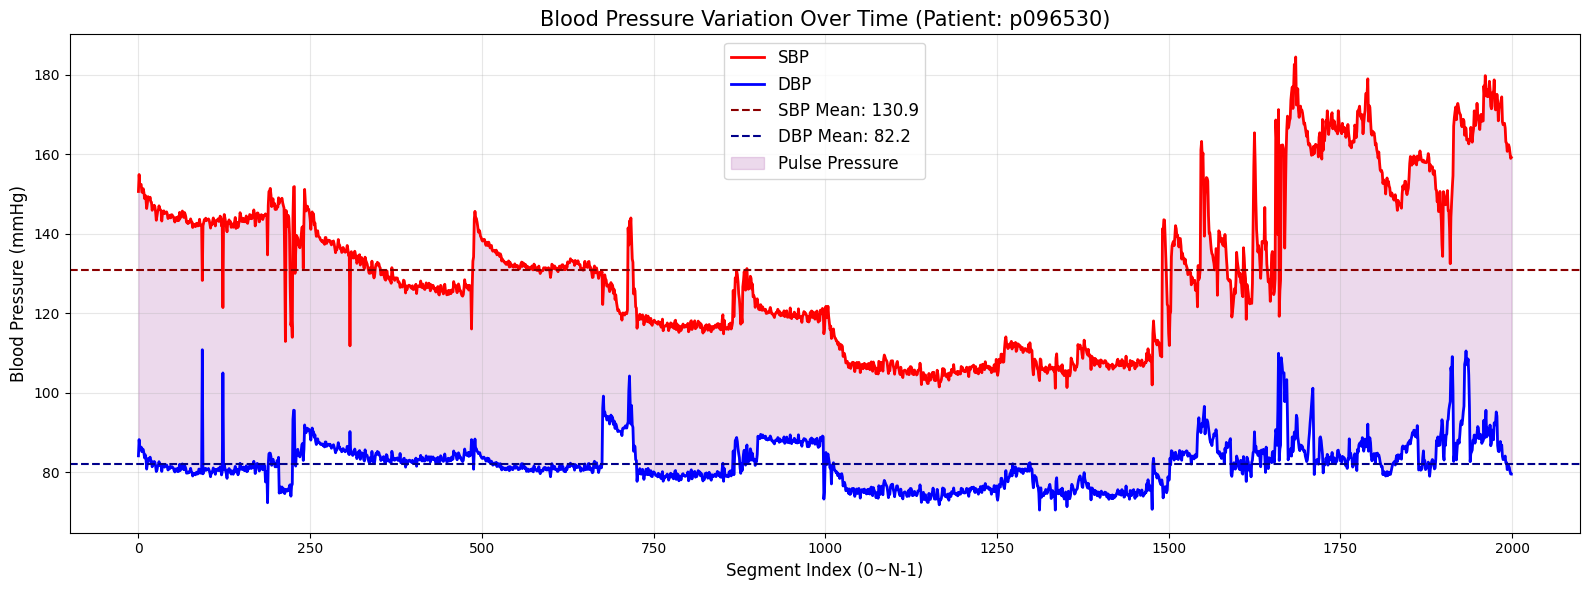

/content/drive/MyDrive/Colab Notebooks/p005521.mat 로드 완료. 환자: p005521, 세그먼트: 2000, 길이: 1250


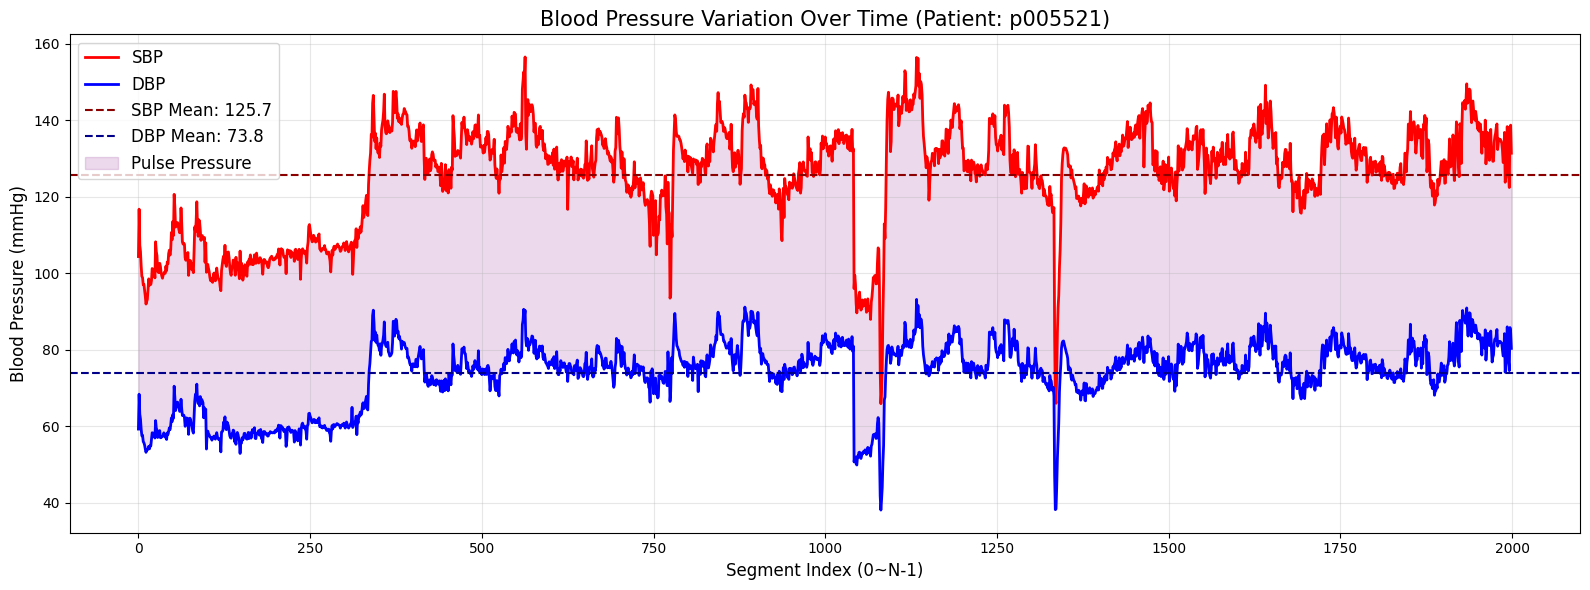


[훈련] 환자 A (p096530) PPG only CNN+GRU 학습 시작
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 10693.4746 - val_loss: 7442.1572
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 7629.4844 - val_loss: 4296.9717
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 4302.1880 - val_loss: 1561.4252
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 1656.5990 - val_loss: 304.2979
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 511.0405 - val_loss: 110.9426
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 331.9580 - val_loss: 123.6132
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 342.1844 - val_loss: 131.3012
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 316.3027 - val_loss: 132.6160
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 332.3673 - val_loss: 131.5974
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 320.2746 - val_loss: 130.1037
Epoch 11/100
40/40 ━━━━━━━━━━━━━

In [11]:
# 4. 실행 예시
# =========================
mat_A = "/content/drive/MyDrive/Colab Notebooks/p096530.mat"
mat_B = "/content/drive/MyDrive/Colab Notebooks/p005521.mat"

results_gru = train_A_and_test_on_A_and_B_gru(mat_A, mat_B)